In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import json
from torch.cuda.amp import GradScaler, autocast
import logging
import time
import pickle
import re
import shutil

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
base_dir = '/home/gagan/Downloads'  # Path to Actor_XX folders
preferred_dir = os.path.join(base_dir, 'audio_speech_actors_01-24')  # Preferred RAVDESS folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 16
transcript_file = 'transcripts.json'
spectrogram_dir = 'spectrograms'
num_workers = 4  # For DataLoader
transcription_batch_size = 16  # For Whisper transcription
max_audio_length = 480000  # 30s at 16kHz
fixed_spec_length = 280  # Fixed time frames for spectrograms

# Clear spectrogram directory to avoid corrupted files
if os.path.exists(spectrogram_dir):
    shutil.rmtree(spectrogram_dir)
os.makedirs(spectrogram_dir, exist_ok=True)

# Check GPU memory
def check_gpu_memory():
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # GB
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        free = total_memory - allocated
        logging.info(f"GPU Memory: Total={total_memory:.2f}GB, Allocated={allocated:.2f}GB, Free={free:.2f}GB")
        return free > 4  # Ensure at least 4GB free for transcription
    else:
        logging.error("CUDA not available")
        return False

# Step 1: Utility Functions
def get_emotion(filename):
    """Extract emotion label from filename."""
    parts = filename.split('-')
    emotion = int(parts[2])
    return emotion - 1  # Map 1-8 to 0-7

def pad_waveform(waveform, target_length=480000):
    """Pad or truncate waveform to target length (30s at 16kHz)."""
    if waveform is None or waveform.numel() == 0:
        logging.error("Empty or invalid waveform")
        return torch.zeros(target_length)
    current_length = waveform.size(-1)
    if current_length > target_length:
        waveform = waveform[..., :target_length]
    elif current_length < target_length:
        pad_amount = target_length - current_length
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount), mode='constant', value=0)
    return waveform

def batch_generate_transcripts(audio_paths, batch_size=16):
    """Generate transcripts for multiple audio files in batches with padded waveforms."""
    if not check_gpu_memory():
        raise RuntimeError("Insufficient GPU memory for transcription")
    
    processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny").to(device)
    transcripts = []
    
    for i in range(0, len(audio_paths), batch_size):
        batch_paths = audio_paths[i:i+batch_size]
        waveforms = []
        valid_paths = []
        for path in batch_paths:
            try:
                waveform, sample_rate = torchaudio.load(path)
                if waveform.numel() == 0 or waveform.shape[0] > 1:
                    logging.error(f"Invalid waveform in {path}: {waveform.shape}")
                    continue
                if sample_rate != 16000:
                    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                    waveform = resampler(waveform)
                waveform = pad_waveform(waveform, max_audio_length)
                waveforms.append(waveform.squeeze(0).numpy())
                valid_paths.append(path)
                logging.debug(f"Waveform length for {os.path.basename(path)}: {waveform.size(-1)} samples")
            except Exception as e:
                logging.error(f"Failed to load {path}: {e}")
                continue
        
        if not waveforms:
            logging.error(f"Batch {i//batch_size + 1} empty, skipping")
            transcripts.extend([""] * len(batch_paths))
            continue
        
        try:
            inputs = processor(
                waveforms,
                return_tensors="pt",
                sampling_rate=16000,
                padding="max_length",
                max_length=3000,
                truncation=False,
                return_attention_mask=True
            ).to(device)
            with torch.no_grad():
                predicted_ids = model.generate(inputs["input_features"], max_length=448)
            batch_transcripts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            transcripts.extend(batch_transcripts + [""] * (len(batch_paths) - len(batch_transcripts)))
            logging.info(f"Transcribed batch {i//batch_size + 1}/{len(audio_paths)//batch_size + 1}")
            del inputs, predicted_ids
        except Exception as e:
            logging.error(f"Batch transcription error for files {valid_paths}: {e}")
            transcripts.extend([""] * len(batch_paths))
        
        torch.cuda.empty_cache()
    
    del model, processor
    torch.cuda.empty_cache()
    return transcripts

def compute_spectrogram(waveform, mel_transform, fixed_length=280):
    """Compute and pad/truncate mel-spectrogram to fixed size [1, 128, fixed_length]."""
    if waveform.numel() == 0 or waveform.shape[0] > 1:
        logging.error("Invalid waveform for spectrogram computation")
        return torch.zeros(1, 128, fixed_length)
    
    # Ensure waveform is mono and at correct sample rate
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mel_spec = mel_transform(waveform)  # [1, 128, T]
    log_mel_spec = torch.log(mel_spec + 1e-6)  # [1, 128, T]
    
    # Pad or truncate to fixed_length
    current_length = log_mel_spec.size(2)
    if current_length > fixed_length:
        log_mel_spec = log_mel_spec[:, :, :fixed_length]
    elif current_length < fixed_length:
        pad_amount = fixed_length - current_length
        log_mel_spec = nn.functional.pad(log_mel_spec, (0, pad_amount), mode='constant', value=0)
    
    # Validate shape
    expected_shape = (1, 128, fixed_length)
    if log_mel_spec.shape != expected_shape:
        logging.error(f"Unexpected spectrogram shape {log_mel_spec.shape}, expected {expected_shape}")
        return torch.zeros(1, 128, fixed_length)
    
    logging.debug(f"Spectrogram shape: {log_mel_spec.shape}")
    return log_mel_spec

# Step 2: Load and Prepare Data
logging.info("Starting data loading")
start_time = time.time()

# Validate RAVDESS filenames and deduplicate
ravdess_pattern = re.compile(r'\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}\.wav')
audio_files = []
seen_files = set()
actor_counts = Counter()
duplicate_files = []
for root, dirs, files in os.walk(base_dir):
    if any(root.endswith(f'Actor_{i:02d}') for i in range(1, 25)):
        actor_id = os.path.basename(root)
        is_preferred = root.startswith(preferred_dir)
        for file in files:
            if file.endswith('.wav') and ravdess_pattern.match(file):
                file_path = os.path.join(root, file)
                if file_path not in seen_files:
                    if is_preferred or not any(fp.startswith(preferred_dir) for fp in seen_files):
                        audio_files.append(file_path)
                        seen_files.add(file_path)
                        actor_counts[actor_id] += 1
                else:
                    duplicate_files.append(file_path)

# Enforce 60 files per actor
filtered_audio_files = []
for actor_id in [f'Actor_{i:02d}' for i in range(1, 25)]:
    actor_files = [f for f in audio_files if os.path.basename(os.path.dirname(f)) == actor_id]
    if len(actor_files) > 60:
        actor_files = sorted(actor_files)[:60]  # Take first 60
        logging.warning(f"Actor {actor_id} has {len(actor_files)} files, keeping 60")
    filtered_audio_files.extend(actor_files)

audio_files = filtered_audio_files

if duplicate_files:
    logging.warning(f"Found {len(duplicate_files)} duplicate files: {duplicate_files[:10]} (showing first 10)")

logging.info(f"Total audio files after validation: {len(audio_files)}")
if len(audio_files) != 1440:
    logging.warning(f"Expected 1440 files, found {len(audio_files)}. Check for duplicates or missing files in {base_dir}")
    logging.info(f"Files per actor: {actor_counts}")

all_data = []
for audio_file in audio_files:
    filename = os.path.basename(audio_file)
    try:
        label = get_emotion(filename)
        all_data.append((audio_file, label))
    except Exception as e:
        logging.error(f"Invalid filename {filename}: {e}")
        continue

# Verify emotion distribution
labels = [label for _, label in all_data]
counter = Counter(labels)
logging.info(f"Emotion distribution: {counter}")

# Load or generate transcripts
if os.path.exists(transcript_file):
    with open(transcript_file, 'r') as f:
        all_transcripts = json.load(f)
else:
    logging.info("Generating transcripts...")
    all_transcripts = batch_generate_transcripts([path for path, _ in all_data], batch_size=transcription_batch_size)
    with open(transcript_file, 'w') as f:
        json.dump(all_transcripts, f)
logging.info(f"Transcription time: {time.time() - start_time:.2f}s")

# Precompute spectrograms
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=48000, n_fft=1024, hop_length=512, n_mels=128
)
spectrogram_paths = []
for idx, (audio_path, label) in enumerate(all_data):
    spec_path = os.path.join(spectrogram_dir, f"spec_{idx}.pkl")
    try:
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != 48000:
            resampler = torchaudio.transforms.Resample(sample_rate, 48000)
            waveform = resampler(waveform)
        log_mel_spec = compute_spectrogram(waveform, mel_transform, fixed_length=fixed_spec_length)
        with open(spec_path, 'wb') as f:
            pickle.dump(log_mel_spec, f)
    except Exception as e:
        logging.error(f"Failed to compute spectrogram for {audio_path}: {e}")
        log_mel_spec = torch.zeros(1, 128, fixed_spec_length)
        with open(spec_path, 'wb') as f:
            pickle.dump(log_mel_spec, f)
    spectrogram_paths.append(spec_path)

# Split data
train_idx, test_idx = train_test_split(
    list(range(len(all_data))),
    test_size=0.2,
    stratify=[label for _, label in all_data]
)
train_data = [(spectrogram_paths[i], all_data[i][1]) for i in train_idx]
test_data = [(spectrogram_paths[i], all_data[i][1]) for i in test_idx]
train_transcripts = [all_transcripts[i] for i in train_idx]
test_transcripts = [all_transcripts[i] for i in test_idx]

# Step 3: Build Vocabulary
all_words = [word for transcript in all_transcripts for word in transcript.lower().split()]
unique_words = list(set(all_words))
vocab = {"<PAD>": 0, "<UNK>": 1}
for i, word in enumerate(unique_words):
    vocab[word] = i + 2
vocab_size = len(vocab)
max_len = max(len(transcript.split()) for transcript in all_transcripts if transcript)  # Typically 6

# Step 4: Define Datasets
class AudioDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.expected_shape = (1, 128, fixed_spec_length)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        try:
            with open(spec_path, 'rb') as f:
                log_mel_spec = pickle.load(f)
            if log_mel_spec.shape != self.expected_shape:
                logging.error(f"Invalid spectrogram shape {log_mel_spec.shape} in {spec_path}, expected {self.expected_shape}")
                return torch.zeros(self.expected_shape), label
            return log_mel_spec, label
        except Exception as e:
            logging.error(f"Failed to load spectrogram {spec_path}: {e}")
            return torch.zeros(self.expected_shape), label

class TextDataset(Dataset):
    def __init__(self, transcripts, labels):
        self.transcripts = transcripts
        self.labels = labels
        self.word_to_idx = {word: idx for word, idx in vocab.items()}
        self.max_len = max_len
    
    def __len__(self):
        return len(self.transcripts)
    
    def __getitem__(self, idx):
        transcript = self.transcripts[idx].lower().split() if self.transcripts[idx] else ["<UNK>"]
        label = self.labels[idx]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in transcript]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), label

class MultimodalDataset(Dataset):
    def __init__(self, data_list, transcripts):
        self.data_list = data_list
        self.transcripts = transcripts
        self.word_to_idx = {word: idx for word, idx in vocab.items()}
        self.max_len = max_len
        self.expected_shape = (1, 128, fixed_spec_length)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        transcript = self.transcripts[idx]
        try:
            with open(spec_path, 'rb') as f:
                log_mel_spec = pickle.load(f)
            if log_mel_spec.shape != self.expected_shape:
                logging.error(f"Invalid spectrogram shape {log_mel_spec.shape} in {spec_path}, expected {self.expected_shape}")
                log_mel_spec = torch.zeros(self.expected_shape)
        except Exception as e:
            logging.error(f"Failed to load spectrogram {spec_path}: {e}")
            log_mel_spec = torch.zeros(self.expected_shape)
        words = transcript.lower().split() if transcript else ["<UNK>"]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in words]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        text_input = torch.tensor(indices, dtype=torch.long)
        return log_mel_spec, text_input, label

# Create datasets and dataloaders
train_audio_dataset = AudioDataset(train_data)
test_audio_dataset = AudioDataset(test_data)
train_text_dataset = TextDataset(train_transcripts, [label for _, label in train_data])
test_text_dataset = TextDataset(test_transcripts, [label for _, label in test_data])
train_multimodal_dataset = MultimodalDataset(train_data, train_transcripts)
test_multimodal_dataset = MultimodalDataset(test_data, test_transcripts)

train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
train_text_loader = DataLoader(train_text_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_text_loader = DataLoader(test_text_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
train_multimodal_loader = DataLoader(train_multimodal_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_multimodal_loader = DataLoader(test_multimodal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Step 5: Define Models
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def get_features(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class TextRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 8)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        out = self.fc(last_hidden.squeeze(0))
        return out
    
    def get_features(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        return last_hidden.squeeze(0)

class MultimodalModel(nn.Module):
    def __init__(self, audio_model, text_model):
        super(MultimodalModel, self).__init__()
        self.audio_model = audio_model
        self.text_model = text_model
        self.fc = nn.Linear(128 + 64, 8)  # Audio: 128, Text: 64
    
    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model.get_features(audio_input)
        text_feat = self.text_model.get_features(text_input)
        combined = torch.cat((audio_feat, text_feat), dim=1)
        out = self.fc(combined)
        return out

# Step 6: Training Function
def train_model(model, loader, criterion, optimizer, epochs, is_multimodal=False, accum_steps=2):
    scaler = GradScaler()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        optimizer.zero_grad()
        for i, batch in enumerate(loader):
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(device), text_input.to(device), labels.to(device)
                    with autocast():
                        outputs = model(audio_input, text_input)
                        loss = criterion(outputs, labels)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                loss = loss / accum_steps
                scaler.scale(loss).backward()
                if (i + 1) % accum_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                running_loss += loss.item() * accum_steps
            except RuntimeError as e:
                logging.error(f"Training error in batch {i}: {e}")
                torch.cuda.empty_cache()
                continue
        logging.info(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}, Time: {time.time() - start_time:.2f}s")

# Step 7: Train Unimodal Models
logging.info("Starting training")
criterion = nn.CrossEntropyLoss()

# Clear memory before training
torch.cuda.empty_cache()

# Audio CNN
audio_model = AudioCNN().to(device)
audio_optimizer = optim.Adam(audio_model.parameters(), lr=0.001)
logging.info("Training Audio CNN...")
train_model(audio_model, train_audio_loader, criterion, audio_optimizer, num_epochs)

# Text RNN
text_model = TextRNN(vocab_size=vocab_size, embedding_dim=32, hidden_dim=64).to(device)
text_optimizer = optim.Adam(text_model.parameters(), lr=0.001)
logging.info("Training Text RNN...")
train_model(text_model, train_text_loader, criterion, text_optimizer, num_epochs)

# Step 8: Train Multimodal Model
multimodal_model = MultimodalModel(audio_model, text_model).to(device)
multimodal_optimizer = optim.Adam(multimodal_model.parameters(), lr=0.001)
logging.info("Training Multimodal Model...")
train_model(multimodal_model, train_multimodal_loader, criterion, multimodal_optimizer, num_epochs, is_multimodal=True)

# Step 9: Evaluate Models
def evaluate_model(model, loader, is_multimodal=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(device), text_input.to(device), labels.to(device)
                    with autocast():
                        outputs = model(audio_input, text_input)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    with autocast():
                        outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            except RuntimeError as e:
                logging.error(f"Evaluation error: {e}")
                continue
    accuracy = 100 * correct / total
    return accuracy

# Evaluate
audio_accuracy = evaluate_model(audio_model, test_audio_loader)
text_accuracy = evaluate_model(text_model, test_text_loader)
multimodal_accuracy = evaluate_model(multimodal_model, test_multimodal_loader, is_multimodal=True)
logging.info(f"Audio CNN Test Accuracy: {audio_accuracy:.2f}%")
logging.info(f"Text RNN Test Accuracy: {text_accuracy:.2f}%")
logging.info(f"Multimodal Model Test Accuracy: {multimodal_accuracy:.2f}%")

2025-05-08 11:08:09,600 - INFO - Starting data loading
2025-05-08 11:08:09,622 - INFO - Total audio files after validation: 1440
2025-05-08 11:08:09,624 - INFO - Emotion distribution: Counter({7: 192, 1: 192, 3: 192, 4: 192, 6: 192, 5: 192, 2: 192, 0: 96})
2025-05-08 11:08:09,625 - INFO - Transcription time: 0.02s
/home/gagan/anaconda3/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
2025-05-08 11:08:09,684 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:08:09,712 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:08:10,195 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:08:11,890 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:08:11,919 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:

In [11]:
"""
Emotion Recognition Pipeline for RAVDESS Dataset

This script implements unimodal (Audio CNN, Text RNN) and multimodal models to classify
8 emotions from the RAVDESS dataset using mel-spectrograms and transcript text.
It includes data preprocessing, model training, and evaluation, with robust error handling
and logging for debugging.

Dependencies: See requirements.txt
Dataset: RAVDESS (1440 audio files, expected in /home/gagan/Downloads/audio_speech_actors_01-24)
Output: Logs training progress and test accuracies
"""

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import json
from torch.cuda.amp import GradScaler, autocast
import logging
import time
import pickle
import re
import shutil

# Setup logging for debugging and progress tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
BASE_DIR = '/home/gagan/Downloads'  # Path to RAVDESS dataset
PREFERRED_DIR = os.path.join(BASE_DIR, 'audio_speech_actors_01-24')  # Preferred folder
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10
BATCH_SIZE = 16
TRANSCRIPT_FILE = 'transcripts.json'
SPECTROGRAM_DIR = 'spectrograms'
NUM_WORKERS = 4
TRANSCRIPTION_BATCH_SIZE = 16
MAX_AUDIO_LENGTH = 480000  # 30s at 16kHz
FIXED_SPEC_LENGTH = 280  # Fixed spectrogram time frames

# Clear spectrogram directory to avoid corrupted files
if os.path.exists(SPECTROGRAM_DIR):
    shutil.rmtree(SPECTROGRAM_DIR)
os.makedirs(SPECTROGRAM_DIR, exist_ok=True)

def check_gpu_memory():
    """Check if sufficient GPU memory is available (>4GB free)."""
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        free = total_memory - allocated
        logging.info(f"GPU Memory: Total={total_memory:.2f}GB, Allocated={allocated:.2f}GB, Free={free:.2f}GB")
        return free > 4
    logging.error("CUDA not available")
    return False

def get_emotion(filename):
    """Extract emotion label (0-7) from RAVDESS filename."""
    parts = filename.split('-')
    emotion = int(parts[2])
    return emotion - 1

def pad_waveform(waveform, target_length=MAX_AUDIO_LENGTH):
    """Pad or truncate waveform to target length."""
    if waveform is None or waveform.numel() == 0:
        logging.error("Empty or invalid waveform")
        return torch.zeros(target_length)
    current_length = waveform.size(-1)
    if current_length > target_length:
        waveform = waveform[..., :target_length]
    elif current_length < target_length:
        pad_amount = target_length - current_length
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount), mode='constant', value=0)
    return waveform

def batch_generate_transcripts(audio_paths, batch_size=TRANSCRIPTION_BATCH_SIZE):
    """Generate transcripts using Whisper in batches."""
    if not check_gpu_memory():
        raise RuntimeError("Insufficient GPU memory for transcription")
    
    processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny").to(DEVICE)
    transcripts = []
    
    for i in range(0, len(audio_paths), batch_size):
        batch_paths = audio_paths[i:i+batch_size]
        waveforms = []
        valid_paths = []
        for path in batch_paths:
            try:
                waveform, sample_rate = torchaudio.load(path)
                if waveform.numel() == 0 or waveform.shape[0] > 1:
                    logging.error(f"Invalid waveform in {path}: {waveform.shape}")
                    continue
                if sample_rate != 16000:
                    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                    waveform = resampler(waveform)
                waveform = pad_waveform(waveform)
                waveforms.append(waveform.squeeze(0).numpy())
                valid_paths.append(path)
                logging.debug(f"Waveform length for {os.path.basename(path)}: {waveform.size(-1)} samples")
            except Exception as e:
                logging.error(f"Failed to load {path}: {e}")
                continue
        
        if not waveforms:
            logging.error(f"Batch {i//batch_size + 1} empty, skipping")
            transcripts.extend([""] * len(batch_paths))
            continue
        
        try:
            inputs = processor(
                waveforms,
                return_tensors="pt",
                sampling_rate=16000,
                padding="max_length",
                max_length=3000,
                truncation=False,
                return_attention_mask=True
            ).to(DEVICE)
            with torch.no_grad():
                predicted_ids = model.generate(inputs["input_features"], max_length=448)
            batch_transcripts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            transcripts.extend(batch_transcripts + [""] * (len(batch_paths) - len(batch_transcripts)))
            logging.info(f"Transcribed batch {i//batch_size + 1}/{len(audio_paths)//batch_size + 1}")
            del inputs, predicted_ids
        except Exception as e:
            logging.error(f"Batch transcription error for files {valid_paths}: {e}")
            transcripts.extend([""] * len(batch_paths))
        
        torch.cuda.empty_cache()
    
    del model, processor
    torch.cuda.empty_cache()
    return transcripts

def compute_spectrogram(waveform, mel_transform, fixed_length=FIXED_SPEC_LENGTH):
    """Compute mel-spectrogram with fixed size [1, 128, fixed_length]."""
    if waveform.numel() == 0 or waveform.shape[0] > 1:
        logging.error("Invalid waveform for spectrogram computation")
        return torch.zeros(1, 128, fixed_length)
    
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mel_spec = mel_transform(waveform)
    log_mel_spec = torch.log(mel_spec + 1e-6)
    
    current_length = log_mel_spec.size(2)
    if current_length > fixed_length:
        log_mel_spec = log_mel_spec[:, :, :fixed_length]
    elif current_length < fixed_length:
        pad_amount = fixed_length - current_length
        log_mel_spec = nn.functional.pad(log_mel_spec, (0, pad_amount), mode='constant', value=0)
    
    expected_shape = (1, 128, fixed_length)
    if log_mel_spec.shape != expected_shape:
        logging.error(f"Unexpected spectrogram shape {log_mel_spec.shape}, expected {expected_shape}")
        return torch.zeros(1, 128, fixed_length)
    
    logging.debug(f"Spectrogram shape: {log_mel_spec.shape}")
    return log_mel_spec

def load_data():
    """Load and preprocess RAVDESS dataset."""
    logging.info("Starting data loading")
    start_time = time.time()
    
    ravdess_pattern = re.compile(r'\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}\.wav')
    audio_files = []
    seen_files = set()
    actor_counts = Counter()
    duplicate_files = []
    
    for root, _, files in os.walk(BASE_DIR):
        if any(root.endswith(f'Actor_{i:02d}') for i in range(1, 25)):
            actor_id = os.path.basename(root)
            is_preferred = root.startswith(PREFERRED_DIR)
            for file in files:
                if file.endswith('.wav') and ravdess_pattern.match(file):
                    file_path = os.path.join(root, file)
                    if file_path not in seen_files:
                        if is_preferred or not any(fp.startswith(PREFERRED_DIR) for fp in seen_files):
                            audio_files.append(file_path)
                            seen_files.add(file_path)
                            actor_counts[actor_id] += 1
                    else:
                        duplicate_files.append(file_path)
    
    filtered_audio_files = []
    for actor_id in [f'Actor_{i:02d}' for i in range(1, 25)]:
        actor_files = [f for f in audio_files if os.path.basename(os.path.dirname(f)) == actor_id]
        if len(actor_files) > 60:
            actor_files = sorted(actor_files)[:60]
            logging.warning(f"Actor {actor_id} has {len(actor_files)} files, keeping 60")
        filtered_audio_files.extend(actor_files)
    
    audio_files = filtered_audio_files
    
    if duplicate_files:
        logging.warning(f"Found {len(duplicate_files)} duplicate files: {duplicate_files[:10]}")
    
    logging.info(f"Total audio files after validation: {len(audio_files)}")
    if len(audio_files) != 1440:
        logging.warning(f"Expected 1440 files, found {len(audio_files)}. Check for duplicates or missing files in {BASE_DIR}")
        logging.info(f"Files per actor: {actor_counts}")
    
    all_data = []
    for audio_file in audio_files:
        filename = os.path.basename(audio_file)
        try:
            label = get_emotion(filename)
            all_data.append((audio_file, label))
        except Exception as e:
            logging.error(f"Invalid filename {filename}: {e}")
            continue
    
    labels = [label for _, label in all_data]
    counter = Counter(labels)
    logging.info(f"Emotion distribution: {counter}")
    
    if os.path.exists(TRANSCRIPT_FILE):
        with open(TRANSCRIPT_FILE, 'r') as f:
            all_transcripts = json.load(f)
    else:
        logging.info("Generating transcripts...")
        all_transcripts = batch_generate_transcripts([path for path, _ in all_data])
        with open(TRANSCRIPT_FILE, 'w') as f:
            json.dump(all_transcripts, f)
    logging.info(f"Transcription time: {time.time() - start_time:.2f}s")
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=48000, n_fft=1024, hop_length=512, n_mels=128
    )
    spectrogram_paths = []
    for idx, (audio_path, label) in enumerate(all_data):
        spec_path = os.path.join(SPECTROGRAM_DIR, f"spec_{idx}.pkl")
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
            if sample_rate != 48000:
                resampler = torchaudio.transforms.Resample(sample_rate, 48000)
                waveform = resampler(waveform)
            log_mel_spec = compute_spectrogram(waveform, mel_transform)
            with open(spec_path, 'wb') as f:
                pickle.dump(log_mel_spec, f)
        except Exception as e:
            logging.error(f"Failed to compute spectrogram for {audio_path}: {e}")
            log_mel_spec = torch.zeros(1, 128, FIXED_SPEC_LENGTH)
            with open(spec_path, 'wb') as f:
                pickle.dump(log_mel_spec, f)
        spectrogram_paths.append(spec_path)
    
    train_idx, test_idx = train_test_split(
        list(range(len(all_data))),
        test_size=0.2,
        stratify=[label for _, label in all_data]
    )
    train_data = [(spectrogram_paths[i], all_data[i][1]) for i in train_idx]
    test_data = [(spectrogram_paths[i], all_data[i][1]) for i in test_idx]
    train_transcripts = [all_transcripts[i] for i in train_idx]
    test_transcripts = [all_transcripts[i] for i in test_idx]
    
    return train_data, test_data, train_transcripts, test_transcripts

def build_vocabulary(transcripts):
    """Build vocabulary from transcripts."""
    all_words = [word for transcript in transcripts for word in transcript.lower().split()]
    unique_words = list(set(all_words))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, word in enumerate(unique_words):
        vocab[word] = i + 2
    max_len = max(len(transcript.split()) for transcript in transcripts if transcript)
    return vocab, max_len

class AudioDataset(Dataset):
    """Dataset for audio spectrograms."""
    def __init__(self, data_list):
        self.data_list = data_list
        self.expected_shape = (1, 128, FIXED_SPEC_LENGTH)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        try:
            with open(spec_path, 'rb') as f:
                log_mel_spec = pickle.load(f)
            if log_mel_spec.shape != self.expected_shape:
                logging.error(f"Invalid spectrogram shape {log_mel_spec.shape} in {spec_path}")
                return torch.zeros(self.expected_shape), label
            return log_mel_spec, label
        except Exception as e:
            logging.error(f"Failed to load spectrogram {spec_path}: {e}")
            return torch.zeros(self.expected_shape), label

class TextDataset(Dataset):
    """Dataset for text transcripts."""
    def __init__(self, transcripts, labels, vocab, max_len):
        self.transcripts = transcripts
        self.labels = labels
        self.word_to_idx = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.transcripts)
    
    def __getitem__(self, idx):
        transcript = self.transcripts[idx].lower().split() if self.transcripts[idx] else ["<UNK>"]
        label = self.labels[idx]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in transcript]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), label

class MultimodalDataset(Dataset):
    """Dataset for combined audio and text data."""
    def __init__(self, data_list, transcripts, vocab, max_len):
        self.data_list = data_list
        self.transcripts = transcripts
        self.word_to_idx = vocab
        self.max_len = max_len
        self.expected_shape = (1, 128, FIXED_SPEC_LENGTH)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        transcript = self.transcripts[idx]
        try:
            with open(spec_path, 'rb') as f:
                log_mel_spec = pickle.load(f)
            if log_mel_spec.shape != self.expected_shape:
                logging.error(f"Invalid spectrogram shape {log_mel_spec.shape} in {spec_path}")
                log_mel_spec = torch.zeros(self.expected_shape)
        except Exception as e:
            logging.error(f"Failed to load spectrogram {spec_path}: {e}")
            log_mel_spec = torch.zeros(self.expected_shape)
        words = transcript.lower().split() if transcript else ["<UNK>"]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in words]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        text_input = torch.tensor(indices, dtype=torch.long)
        return log_mel_spec, text_input, label

class AudioCNN(nn.Module):
    """CNN for audio spectrogram emotion classification."""
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def get_features(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class TextRNN(nn.Module):
    """RNN (LSTM) for text transcript emotion classification."""
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 8)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out
    
    def get_features(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        return hidden[-1]

class MultimodalModel(nn.Module):
    """Multimodal model combining audio and text features."""
    def __init__(self, audio_model, text_model):
        super(MultimodalModel, self).__init__()
        self.audio_model = audio_model
        self.text_model = text_model
        self.fc = nn.Linear(128 + 64, 8)
    
    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model.get_features(audio_input)
        text_feat = self.text_model.get_features(text_input)
        combined = torch.cat((audio_feat, text_feat), dim=1)
        out = self.fc(combined)
        return out

def train_model(model, loader, criterion, optimizer, epochs=NUM_EPOCHS, is_multimodal=False, accum_steps=2):
    """Train a model with gradient accumulation and mixed precision."""
    scaler = GradScaler()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        optimizer.zero_grad()
        for i, batch in enumerate(loader):
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(DEVICE), text_input.to(DEVICE), labels.to(DEVICE)
                    with autocast():
                        outputs = model(audio_input, text_input)
                        loss = criterion(outputs, labels)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                loss = loss / accum_steps
                scaler.scale(loss).backward()
                if (i + 1) % accum_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                running_loss += loss.item() * accum_steps
            except RuntimeError as e:
                logging.error(f"Training error in batch {i}: {e}")
                torch.cuda.empty_cache()
                continue
        logging.info(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}, Time: {time.time() - start_time:.2f}s")

def evaluate_model(model, loader, is_multimodal=False):
    """Evaluate model accuracy on test set."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(DEVICE), text_input.to(DEVICE), labels.to(DEVICE)
                    with autocast():
                        outputs = model(audio_input, text_input)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    with autocast():
                        outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            except RuntimeError as e:
                logging.error(f"Evaluation error: {e}")
                continue
    accuracy = 100 * correct / total
    return accuracy

def main():
    """Main function to run the emotion recognition pipeline."""
    # Load and preprocess data
    train_data, test_data, train_transcripts, test_transcripts = load_data()
    
    # Build vocabulary
    vocab, max_len = build_vocabulary(train_transcripts + test_transcripts)
    
    # Create datasets
    train_audio_dataset = AudioDataset(train_data)
    test_audio_dataset = AudioDataset(test_data)
    train_text_dataset = TextDataset(train_transcripts, [label for _, label in train_data], vocab, max_len)
    test_text_dataset = TextDataset(test_transcripts, [label for _, label in test_data], vocab, max_len)
    train_multimodal_dataset = MultimodalDataset(train_data, train_transcripts, vocab, max_len)
    test_multimodal_dataset = MultimodalDataset(test_data, test_transcripts, vocab, max_len)
    
    # Create dataloaders
    train_audio_loader = DataLoader(train_audio_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_audio_loader = DataLoader(test_audio_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    train_text_loader = DataLoader(train_text_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_text_loader = DataLoader(test_text_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    train_multimodal_loader = DataLoader(train_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_multimodal_loader = DataLoader(test_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize models
    criterion = nn.CrossEntropyLoss()
    torch.cuda.empty_cache()
    
    # Train Audio CNN
    audio_model = AudioCNN().to(DEVICE)
    audio_optimizer = optim.Adam(audio_model.parameters(), lr=0.001)
    logging.info("Training Audio CNN...")
    train_model(audio_model, train_audio_loader, criterion, audio_optimizer)
    
    # Train Text RNN
    text_model = TextRNN(len(vocab), embedding_dim=32, hidden_dim=64).to(DEVICE)
    text_optimizer = optim.Adam(text_model.parameters(), lr=0.001)
    logging.info("Training Text RNN...")
    train_model(text_model, train_text_loader, criterion, text_optimizer)
    
    # Train Multimodal Model
    multimodal_model = MultimodalModel(audio_model, text_model).to(DEVICE)
    multimodal_optimizer = optim.Adam(multimodal_model.parameters(), lr=0.001)
    logging.info("Training Multimodal Model...")
    train_model(multimodal_model, train_multimodal_loader, criterion, multimodal_optimizer, is_multimodal=True)
    
    # Evaluate models
    audio_accuracy = evaluate_model(audio_model, test_audio_loader)
    text_accuracy = evaluate_model(text_model, test_text_loader)
    multimodal_accuracy = evaluate_model(multimodal_model, test_multimodal_loader, is_multimodal=True)
    logging.info(f"Audio CNN Test Accuracy: {audio_accuracy:.2f}%")
    logging.info(f"Text RNN Test Accuracy: {text_accuracy:.2f}%")
    logging.info(f"Multimodal Model Test Accuracy: {multimodal_accuracy:.2f}%")

if __name__ == "__main__":
    main()

2025-05-08 11:18:32,420 - INFO - Starting data loading
2025-05-08 11:18:32,437 - INFO - Total audio files after validation: 1440
2025-05-08 11:18:32,438 - INFO - Emotion distribution: Counter({7: 192, 1: 192, 3: 192, 4: 192, 6: 192, 5: 192, 2: 192, 0: 96})
2025-05-08 11:18:32,438 - INFO - Transcription time: 0.02s
/home/gagan/anaconda3/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
2025-05-08 11:18:32,491 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:18:32,512 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:18:32,980 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:18:34,614 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:18:34,639 - ERROR - Invalid waveform for spectrogram computation
2025-05-08 11:

2025-05-08 14:38:41,969 - INFO - Starting data loading
2025-05-08 14:38:41,991 - INFO - Total audio files after validation: 1440
2025-05-08 14:38:41,993 - INFO - Emotion distribution: Counter({7: 192, 1: 192, 3: 192, 4: 192, 6: 192, 5: 192, 2: 192, 0: 96})


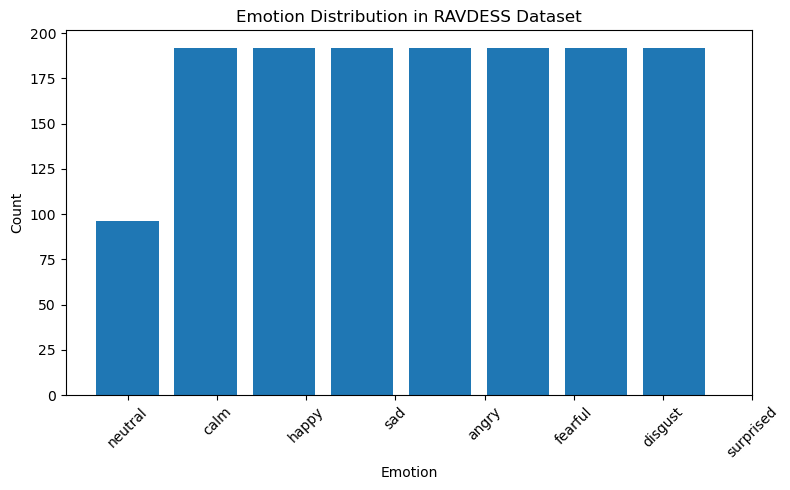

/home/gagan/anaconda3/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
2025-05-08 14:38:42,369 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:38:42,419 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:38:43,247 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:38:46,010 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:38:46,061 - ERROR - Invalid waveform for spectrogram


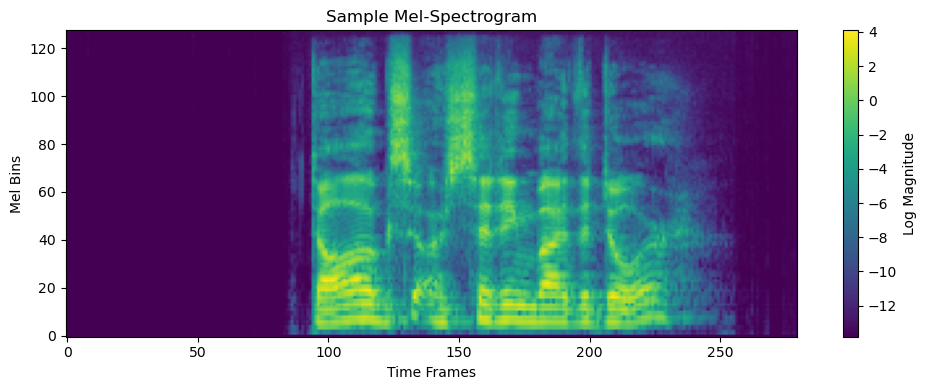

2025-05-08 14:38:47,009 - INFO - Data loading completed in 5.04s
2025-05-08 14:38:47,093 - INFO - Training Audio CNN...
/tmp/ipykernel_21035/871128298.py:496: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_21035/871128298.py:516: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
2025-05-08 14:38:48,687 - INFO - Epoch 1, Loss: 1.9829, Time: 1.59s
2025-05-08 14:38:49,966 - INFO - Epoch 2, Loss: 1.8807, Time: 1.28s
2025-05-08 14:38:51,331 - INFO - Epoch 3, Loss: 1.8175, Time: 1.36s
2025-05-08 14:38:52,715 - INFO - Epoch 4, Loss: 1.7690, Time: 1.38s
2025-05-08 14:38:54,146 - INFO - Epoch 5, Loss: 1.7385, Time: 1.43s
2025-05-08 14:38:55,541 - INFO - Epoch 6, Loss: 1.6875, Time: 1.39s
2025-05-08 14:38:56,865 - INFO - Epoch 7, Loss: 1.5948, Time: 1.32s
2025-05-08 14:38:58,208 - INFO - 

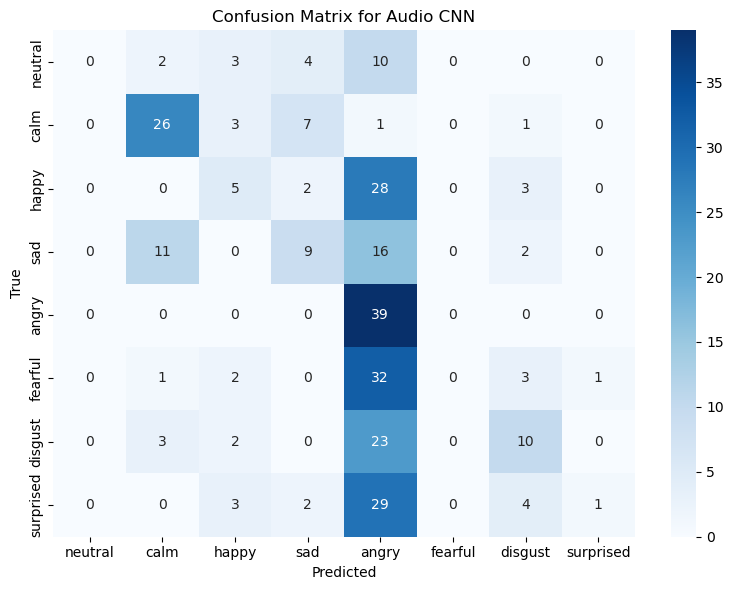

2025-05-08 14:39:01,105 - INFO - Audio CNN Test Accuracy: 31.25%


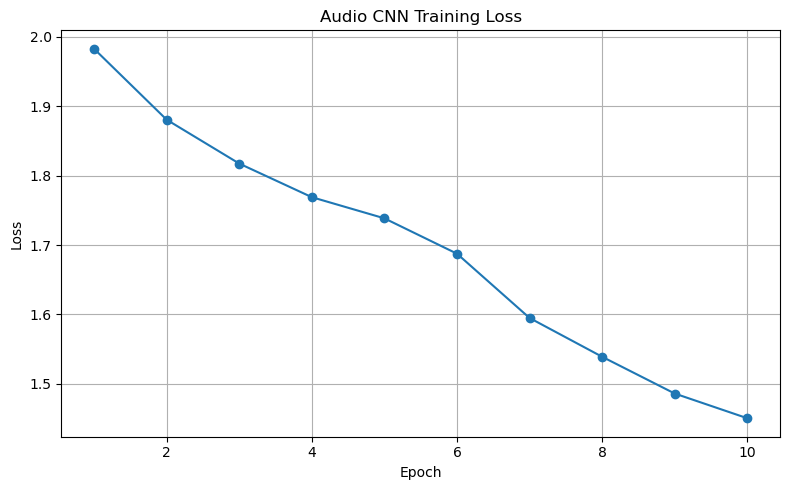

2025-05-08 14:39:01,177 - INFO - Training Text RNN...
/tmp/ipykernel_21035/871128298.py:496: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_21035/871128298.py:516: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
2025-05-08 14:39:02,250 - INFO - Epoch 1, Loss: 2.0791, Time: 1.07s
2025-05-08 14:39:03,307 - INFO - Epoch 2, Loss: 2.0664, Time: 1.06s
2025-05-08 14:39:04,582 - INFO - Epoch 3, Loss: 2.0654, Time: 1.27s
2025-05-08 14:39:05,936 - INFO - Epoch 4, Loss: 2.0669, Time: 1.35s
2025-05-08 14:39:07,259 - INFO - Epoch 5, Loss: 2.0660, Time: 1.32s
2025-05-08 14:39:08,421 - INFO - Epoch 6, Loss: 2.0652, Time: 1.16s
2025-05-08 14:39:09,780 - INFO - Epoch 7, Loss: 2.0628, Time: 1.36s
2025-05-08 14:39:11,045 - INFO - Epoch 8, Loss: 2.0628, Time: 1.26s
2025-05-08 14:39:12,289 - INFO 

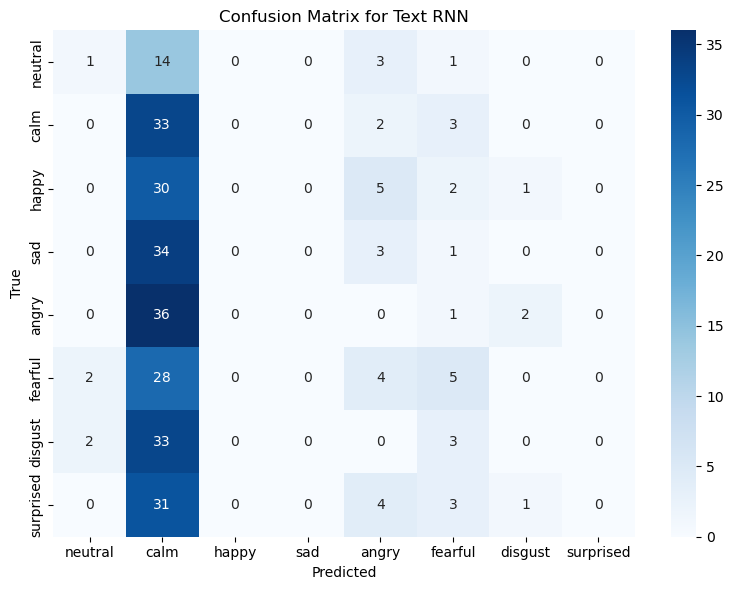

2025-05-08 14:39:14,190 - INFO - Text RNN Test Accuracy: 13.54%


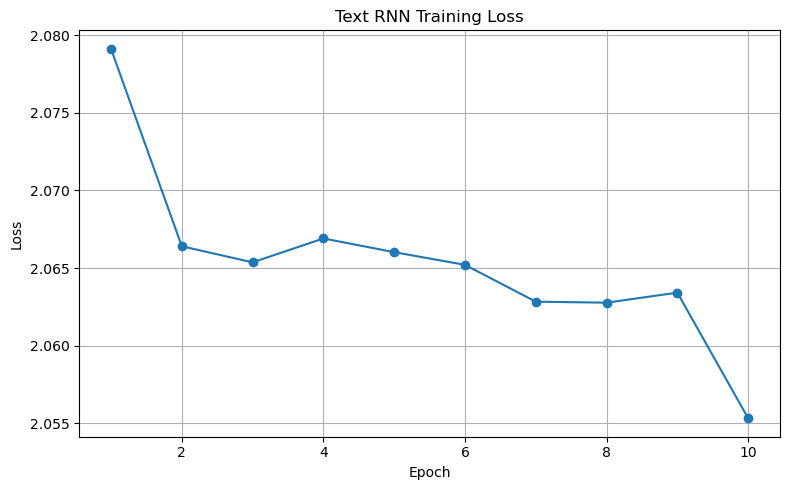

2025-05-08 14:39:14,272 - INFO - Training Multimodal Model...
/tmp/ipykernel_21035/871128298.py:496: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_21035/871128298.py:510: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
2025-05-08 14:39:14,473 - ERROR - Training error in batch 0: mat1 and mat2 shapes cannot be multiplied (16x384 and 768x256)
2025-05-08 14:39:14,507 - ERROR - Training error in batch 1: mat1 and mat2 shapes cannot be multiplied (16x384 and 768x256)
2025-05-08 14:39:14,523 - ERROR - Training error in batch 2: mat1 and mat2 shapes cannot be multiplied (16x384 and 768x256)
2025-05-08 14:39:14,537 - ERROR - Training error in batch 3: mat1 and mat2 shapes cannot be multiplied (16x384 and 768x256)
2025-05-08 14:39:14,554 - ERROR - Training error in batch 4: mat1 and m

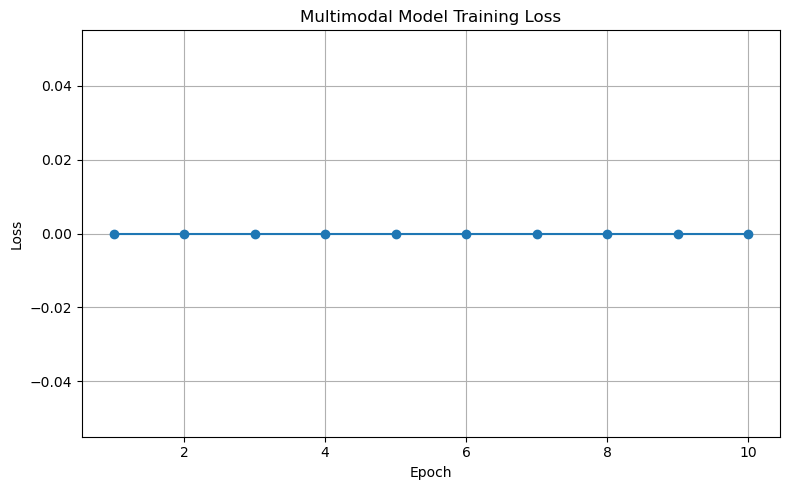

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np
import json
from torch.cuda.amp import GradScaler, autocast
import logging
import time
import pickle
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
base_dir = '/home/gagan/Downloads'  # Path to Actor_XX folders
preferred_dir = os.path.join(base_dir, 'audio_speech_actors_01-24')  # Preferred RAVDESS folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 16
transcript_file = 'transcripts.json'
spectrogram_dir = 'spectrograms'
num_workers = 4
transcription_batch_size = 16
max_audio_length = 480000  # 30s at 16kHz
fixed_spec_length = 280  # Fixed time frames for spectrograms
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Clear spectrogram directory
if os.path.exists(spectrogram_dir):
    shutil.rmtree(spectrogram_dir)
os.makedirs(spectrogram_dir, exist_ok=True)

def check_gpu_memory():
    """Check if sufficient GPU memory is available (>4GB free)."""
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        free = total_memory - allocated
        logging.info(f"GPU Memory: Total={total_memory:.2f}GB, Allocated={allocated:.2f}GB, Free={free:.2f}GB")
        return free > 4
    logging.error("CUDA not available")
    return False

def get_emotion(filename):
    """Extract emotion label from filename (0-7)."""
    try:
        parts = filename.split('-')
        emotion = int(parts[2])
        return emotion - 1
    except Exception as e:
        logging.error(f"Invalid filename format {filename}: {e}")
        return -1

def pad_waveform(waveform, target_length=480000):
    """Pad or truncate waveform to target length."""
    if waveform is None or waveform.numel() == 0:
        logging.error("Empty or invalid waveform")
        return torch.zeros(target_length)
    current_length = waveform.size(-1)
    if current_length > target_length:
        waveform = waveform[..., :target_length]
    elif current_length < target_length:
        pad_amount = target_length - current_length
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount), mode='constant', value=0)
    return waveform

def batch_generate_transcripts(audio_paths, batch_size=16):
    """Generate transcripts using Whisper in batches."""
    if not check_gpu_memory():
        raise RuntimeError("Insufficient GPU memory for transcription")
    
    processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny").to(device)
    transcripts = []
    
    for i in range(0, len(audio_paths), batch_size):
        batch_paths = audio_paths[i:i+batch_size]
        waveforms = []
        valid_paths = []
        for path in batch_paths:
            try:
                waveform, sample_rate = torchaudio.load(path)
                if waveform.numel() == 0 or waveform.shape[0] > 1:
                    logging.error(f"Invalid waveform in {path}: {waveform.shape}")
                    continue
                if sample_rate != 16000:
                    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                    waveform = resampler(waveform)
                waveform = pad_waveform(waveform, max_audio_length)
                waveforms.append(waveform.squeeze(0).numpy())
                valid_paths.append(path)
            except Exception as e:
                logging.error(f"Failed to load {path}: {e}")
                continue
        
        if not waveforms:
            logging.error(f"Batch {i//batch_size + 1} empty, skipping")
            transcripts.extend([""] * len(batch_paths))
            continue
        
        try:
            inputs = processor(
                waveforms,
                return_tensors="pt",
                sampling_rate=16000,
                padding="max_length",
                max_length=3000,
                truncation=False,
                return_attention_mask=True
            ).to(device)
            with torch.no_grad():
                predicted_ids = model.generate(inputs["input_features"], max_length=448)
            batch_transcripts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            transcripts.extend(batch_transcripts + [""] * (len(batch_paths) - len(batch_transcripts)))
            logging.info(f"Transcribed batch {i//batch_size + 1}/{len(audio_paths)//batch_size + 1}")
            del inputs, predicted_ids
        except Exception as e:
            logging.error(f"Batch transcription error for files {valid_paths}: {e}")
            transcripts.extend([""] * len(batch_paths))
        
        torch.cuda.empty_cache()
    
    del model, processor
    torch.cuda.empty_cache()
    return transcripts

def compute_spectrogram(waveform, mel_transform, fixed_length=280):
    """Compute and pad/truncate mel-spectrogram to [1, 128, fixed_length]."""
    if waveform.numel() == 0 or waveform.shape[0] > 1:
        logging.error("Invalid waveform for spectrogram")
        return torch.zeros(1, 128, fixed_length)
    
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mel_spec = mel_transform(waveform)
    log_mel_spec = torch.log(mel_spec + 1e-6)
    
    current_length = log_mel_spec.size(2)
    if current_length > fixed_length:
        log_mel_spec = log_mel_spec[:, :, :fixed_length]
    elif current_length < fixed_length:
        pad_amount = fixed_length - current_length
        log_mel_spec = nn.functional.pad(log_mel_spec, (0, pad_amount), mode='constant', value=0)
    
    expected_shape = (1, 128, fixed_length)
    if log_mel_spec.shape != expected_shape:
        logging.error(f"Unexpected spectrogram shape {log_mel_spec.shape}, expected {expected_shape}")
        return torch.zeros(1, 128, fixed_length)
    
    return log_mel_spec

def load_data():
    """Load and preprocess RAVDESS dataset."""
    logging.info("Starting data loading")
    start_time = time.time()
    
    ravdess_pattern = re.compile(r'\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}\.wav')
    audio_files = []
    seen_files = set()
    actor_counts = Counter()
    duplicate_files = []
    
    for root, _, files in os.walk(base_dir):
        if any(root.endswith(f'Actor_{i:02d}') for i in range(1, 25)):
            actor_id = os.path.basename(root)
            is_preferred = root.startswith(preferred_dir)
            for file in files:
                if file.endswith('.wav') and ravdess_pattern.match(file):
                    file_path = os.path.join(root, file)
                    if file_path not in seen_files:
                        if is_preferred or not any(fp.startswith(preferred_dir) for fp in seen_files):
                            audio_files.append(file_path)
                            seen_files.add(file_path)
                            actor_counts[actor_id] += 1
                    else:
                        duplicate_files.append(file_path)
    
    filtered_audio_files = []
    for actor_id in [f'Actor_{i:02d}' for i in range(1, 25)]:
        actor_files = [f for f in audio_files if os.path.basename(os.path.dirname(f)) == actor_id]
        if len(actor_files) > 60:
            actor_files = sorted(actor_files)[:60]
            logging.warning(f"Actor {actor_id} has {len(actor_files)} files, keeping 60")
        filtered_audio_files.extend(actor_files)
    
    audio_files = filtered_audio_files
    
    if duplicate_files:
        logging.warning(f"Found {len(duplicate_files)} duplicate files: {duplicate_files[:10]}")
    
    logging.info(f"Total audio files after validation: {len(audio_files)}")
    if len(audio_files) != 1440:
        logging.warning(f"Expected 1440 files, found {len(audio_files)}")
    
    all_data = []
    for audio_file in audio_files:
        filename = os.path.basename(audio_file)
        label = get_emotion(filename)
        if label >= 0:
            all_data.append((audio_file, label))
    
    labels = [label for _, label in all_data]
    counter = Counter(labels)
    logging.info(f"Emotion distribution: {counter}")
    
    # Visualize emotion distribution
    plt.figure(figsize=(8, 5))
    plt.hist(labels, bins=8, align='left', rwidth=0.8)
    plt.xticks(range(8), emotion_labels, rotation=45)
    plt.title("Emotion Distribution in RAVDESS Dataset")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    if os.path.exists(transcript_file):
        with open(transcript_file, 'r') as f:
            all_transcripts = json.load(f)
    else:
        logging.info("Generating transcripts...")
        all_transcripts = batch_generate_transcripts([path for path, _ in all_data])
        with open(transcript_file, 'w') as f:
            json.dump(all_transcripts, f)
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=48000, n_fft=1024, hop_length=512, n_mels=128
    )
    spectrogram_paths = []
    sample_spectrogram = None
    for idx, (audio_path, label) in enumerate(all_data):
        spec_path = os.path.join(spectrogram_dir, f"spec_{idx}.pkl")
        for attempt in range(2):  # Retry once for corrupted files
            try:
                waveform, sample_rate = torchaudio.load(audio_path)
                if sample_rate != 48000:
                    resampler = torchaudio.transforms.Resample(sample_rate, 48000)
                    waveform = resampler(waveform)
                log_mel_spec = compute_spectrogram(waveform, mel_transform, fixed_length=fixed_spec_length)
                with open(spec_path, 'wb') as f:
                    pickle.dump(log_mel_spec, f)
                if idx == 0:  # Save first spectrogram for visualization
                    sample_spectrogram = log_mel_spec.squeeze(0).numpy()
                break
            except Exception as e:
                logging.error(f"Attempt {attempt+1} failed for {audio_path}: {e}")
                if attempt == 1:
                    log_mel_spec = torch.zeros(1, 128, fixed_spec_length)
                    with open(spec_path, 'wb') as f:
                        pickle.dump(log_mel_spec, f)
        spectrogram_paths.append(spec_path)
    
    # Visualize sample spectrogram
    if sample_spectrogram is not None:
        plt.figure(figsize=(10, 4))
        plt.imshow(sample_spectrogram, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Log Magnitude')
        plt.title("Sample Mel-Spectrogram")
        plt.xlabel("Time Frames")
        plt.ylabel("Mel Bins")
        plt.tight_layout()
        plt.show()
    
    train_idx, test_idx = train_test_split(
        list(range(len(all_data))),
        test_size=0.2,
        stratify=[label for _, label in all_data],
        random_state=42
    )
    train_data = [(spectrogram_paths[i], all_data[i][1]) for i in train_idx]
    test_data = [(spectrogram_paths[i], all_data[i][1]) for i in test_idx]
    train_transcripts = [all_transcripts[i] for i in train_idx]
    test_transcripts = [all_transcripts[i] for i in test_idx]
    
    logging.info(f"Data loading completed in {time.time() - start_time:.2f}s")
    return train_data, test_data, train_transcripts, test_transcripts, mel_transform

def build_vocabulary(transcripts):
    """Build vocabulary from transcripts."""
    all_words = [word for transcript in transcripts for word in transcript.lower().split()]
    unique_words = list(set(all_words))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, word in enumerate(unique_words):
        vocab[word] = i + 2
    max_len = max(len(transcript.split()) for transcript in transcripts if transcript) or 1
    return vocab, max_len

class AudioDataset(Dataset):
    """Dataset for audio spectrograms."""
    def __init__(self, data_list):
        self.data_list = data_list
        self.expected_shape = (1, 128, fixed_spec_length)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        for attempt in range(2):
            try:
                with open(spec_path, 'rb') as f:
                    log_mel_spec = pickle.load(f)
                if log_mel_spec.shape != self.expected_shape:
                    logging.error(f"Invalid shape {log_mel_spec.shape} in {spec_path}")
                    return torch.zeros(self.expected_shape), label
                return log_mel_spec, label
            except Exception as e:
                logging.error(f"Attempt {attempt+1} failed to load {spec_path}: {e}")
                if attempt == 1:
                    return torch.zeros(self.expected_shape), label

class TextDataset(Dataset):
    """Dataset for text transcripts."""
    def __init__(self, transcripts, labels, vocab, max_len):
        self.transcripts = transcripts
        self.labels = labels
        self.word_to_idx = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.transcripts)
    
    def __getitem__(self, idx):
        transcript = self.transcripts[idx].lower().split() if self.transcripts[idx] else ["<UNK>"]
        label = self.labels[idx]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in transcript]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), label

class MultimodalDataset(Dataset):
    """Dataset for audio and text data."""
    def __init__(self, data_list, transcripts, vocab, max_len):
        self.data_list = data_list
        self.transcripts = transcripts
        self.word_to_idx = vocab
        self.max_len = max_len
        self.expected_shape = (1, 128, fixed_spec_length)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        transcript = self.transcripts[idx]
        for attempt in range(2):
            try:
                with open(spec_path, 'rb') as f:
                    log_mel_spec = pickle.load(f)
                if log_mel_spec.shape != self.expected_shape:
                    logging.error(f"Invalid shape {log_mel_spec.shape} in {spec_path}")
                    log_mel_spec = torch.zeros(self.expected_shape)
                break
            except Exception as e:
                logging.error(f"Attempt {attempt+1} failed to load {spec_path}: {e}")
                if attempt == 1:
                    log_mel_spec = torch.zeros(self.expected_shape)
        words = transcript.lower().split() if transcript else ["<UNK>"]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in words]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        text_input = torch.tensor(indices, dtype=torch.long)
        return log_mel_spec, text_input, label

class AudioCNN(nn.Module):
    """Enhanced CNN for spectrogram emotion classification."""
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def get_features(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return x

class TextRNN(nn.Module):
    """Enhanced bidirectional LSTM for text emotion classification."""
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate forward and backward
        out = self.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
    def get_features(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.relu(self.fc1(hidden))

class MultimodalModel(nn.Module):
    """Enhanced multimodal model combining audio and text features."""
    def __init__(self, audio_model, text_model):
        super(MultimodalModel, self).__init__()
        self.audio_model = audio_model
        self.text_model = text_model
        self.fc1 = nn.Linear(512 + 256, 256)  # Audio: 512, Text: 256 (bidirectional)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model.get_features(audio_input)
        text_feat = self.text_model.get_features(text_input)
        combined = torch.cat((audio_feat, text_feat), dim=1)
        x = self.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

def train_model(model, loader, criterion, optimizer, epochs, is_multimodal=False, accum_steps=2):
    """Train model and return loss history."""
    scaler = GradScaler()
    losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        optimizer.zero_grad()
        
        for i, batch in enumerate(loader):
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(device), text_input.to(device), labels.to(device)
                    with autocast():
                        outputs = model(audio_input, text_input)
                        loss = criterion(outputs, labels)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                loss = loss / accum_steps
                scaler.scale(loss).backward()
                if (i + 1) % accum_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                running_loss += loss.item() * accum_steps
            except RuntimeError as e:
                logging.error(f"Training error in batch {i}: {e}")
                torch.cuda.empty_cache()
                continue
        
        epoch_loss = running_loss / len(loader)
        losses.append(epoch_loss)
        logging.info(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")
    
    return losses

def evaluate_model(model, loader, is_multimodal=False, model_name="Model"):
    """Evaluate model and display confusion matrix."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(device), text_input.to(device), labels.to(device)
                    with autocast():
                        outputs = model(audio_input, text_input)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    with autocast():
                        outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                logging.error(f"Evaluation error: {e}")
                continue
    
    if total == 0:
        logging.error(f"No valid samples evaluated for {model_name}")
        return 0.0
    
    accuracy = 100 * correct / total
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(8))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return accuracy

def main():
    """Main function to run the enhanced emotion recognition pipeline."""
    # Load data
    train_data, test_data, train_transcripts, test_transcripts, mel_transform = load_data()
    
    # Build vocabulary
    vocab, max_len = build_vocabulary(train_transcripts + test_transcripts)
    
    # Create datasets
    train_audio_dataset = AudioDataset(train_data)
    test_audio_dataset = AudioDataset(test_data)
    train_text_dataset = TextDataset(train_transcripts, [label for _, label in train_data], vocab, max_len)
    test_text_dataset = TextDataset(test_transcripts, [label for _, label in test_data], vocab, max_len)
    train_multimodal_dataset = MultimodalDataset(train_data, train_transcripts, vocab, max_len)
    test_multimodal_dataset = MultimodalDataset(test_data, test_transcripts, vocab, max_len)
    
    # Create dataloaders
    train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    train_text_loader = DataLoader(train_text_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_text_loader = DataLoader(test_text_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    train_multimodal_loader = DataLoader(train_multimodal_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_multimodal_loader = DataLoader(test_multimodal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Initialize models
    criterion = nn.CrossEntropyLoss()
    torch.cuda.empty_cache()
    
    # Train Audio CNN
    audio_model = AudioCNN().to(device)
    audio_optimizer = optim.Adam(audio_model.parameters(), lr=0.001)
    logging.info("Training Audio CNN...")
    audio_losses = train_model(audio_model, train_audio_loader, criterion, audio_optimizer, num_epochs)
    audio_accuracy = evaluate_model(audio_model, test_audio_loader, model_name="Audio CNN")
    logging.info(f"Audio CNN Test Accuracy: {audio_accuracy:.2f}%")
    
    # Plot Audio CNN loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), audio_losses, marker='o')
    plt.title("Audio CNN Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    torch.cuda.empty_cache()
    
    # Train Text RNN
    text_model = TextRNN(len(vocab), embedding_dim=64, hidden_dim=128).to(device)
    text_optimizer = optim.Adam(text_model.parameters(), lr=0.001)
    logging.info("Training Text RNN...")
    text_losses = train_model(text_model, train_text_loader, criterion, text_optimizer, num_epochs)
    text_accuracy = evaluate_model(text_model, test_text_loader, model_name="Text RNN")
    logging.info(f"Text RNN Test Accuracy: {text_accuracy:.2f}%")
    
    # Plot Text RNN loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), text_losses, marker='o')
    plt.title("Text RNN Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    torch.cuda.empty_cache()
    
    # Train Multimodal Model
    multimodal_model = MultimodalModel(audio_model, text_model).to(device)
    multimodal_optimizer = optim.Adam(multimodal_model.parameters(), lr=0.001)
    logging.info("Training Multimodal Model...")
    multimodal_losses = train_model(multimodal_model, train_multimodal_loader, criterion, multimodal_optimizer, num_epochs, is_multimodal=True)
    multimodal_accuracy = evaluate_model(multimodal_model, test_multimodal_loader, is_multimodal=True, model_name="Multimodal")
    logging.info(f"Multimodal Model Test Accuracy: {multimodal_accuracy:.2f}%")
    
    # Plot Multimodal loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), multimodal_losses, marker='o')
    plt.title("Multimodal Model Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

2025-05-08 14:48:06,603 - INFO - Starting data loading
2025-05-08 14:48:06,676 - INFO - Total audio files after validation: 1440
2025-05-08 14:48:06,677 - INFO - Emotion distribution: Counter({7: 192, 1: 192, 3: 192, 4: 192, 6: 192, 5: 192, 2: 192, 0: 96})


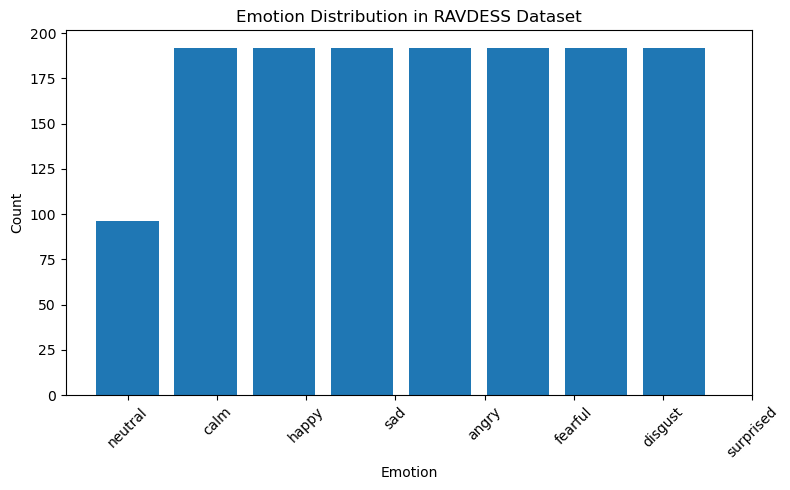

/home/gagan/anaconda3/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
2025-05-08 14:48:06,838 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:48:06,872 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:48:07,469 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:48:09,545 - ERROR - Invalid waveform for spectrogram
2025-05-08 14:48:09,584 - ERROR - Invalid waveform for spectrogram


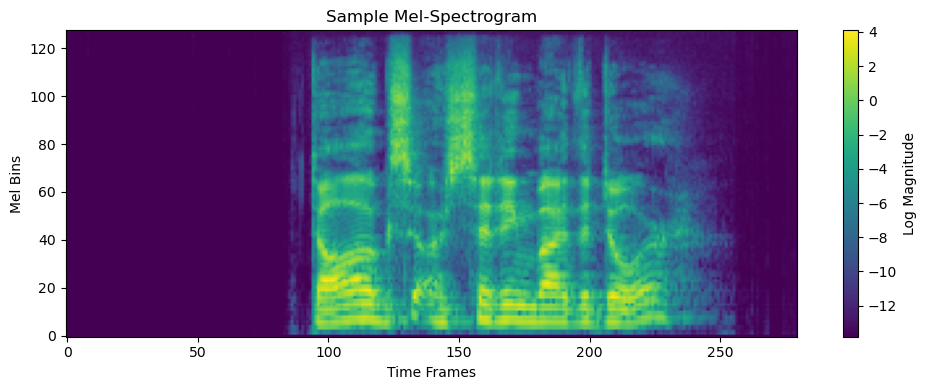

2025-05-08 14:48:10,315 - INFO - Data loading completed in 3.71s
2025-05-08 14:48:10,371 - INFO - Training Audio CNN...
2025-05-08 14:48:11,736 - INFO - Epoch 1, Loss: 1.9467, Time: 1.36s
2025-05-08 14:48:12,738 - INFO - Epoch 2, Loss: 1.8679, Time: 1.00s
2025-05-08 14:48:13,872 - INFO - Epoch 3, Loss: 1.7984, Time: 1.13s
2025-05-08 14:48:15,267 - INFO - Epoch 4, Loss: 1.7444, Time: 1.39s
2025-05-08 14:48:16,637 - INFO - Epoch 5, Loss: 1.6919, Time: 1.37s
2025-05-08 14:48:17,983 - INFO - Epoch 6, Loss: 1.6119, Time: 1.34s
2025-05-08 14:48:18,972 - INFO - Epoch 7, Loss: 1.5361, Time: 0.99s
2025-05-08 14:48:19,977 - INFO - Epoch 8, Loss: 1.4793, Time: 1.00s
2025-05-08 14:48:21,264 - INFO - Epoch 9, Loss: 1.4334, Time: 1.29s
2025-05-08 14:48:22,596 - INFO - Epoch 10, Loss: 1.3273, Time: 1.33s
2025-05-08 14:48:23,942 - INFO - Epoch 11, Loss: 1.3909, Time: 1.34s
2025-05-08 14:48:25,270 - INFO - Epoch 12, Loss: 1.2510, Time: 1.33s
2025-05-08 14:48:26,722 - INFO - Epoch 13, Loss: 1.2217, Time

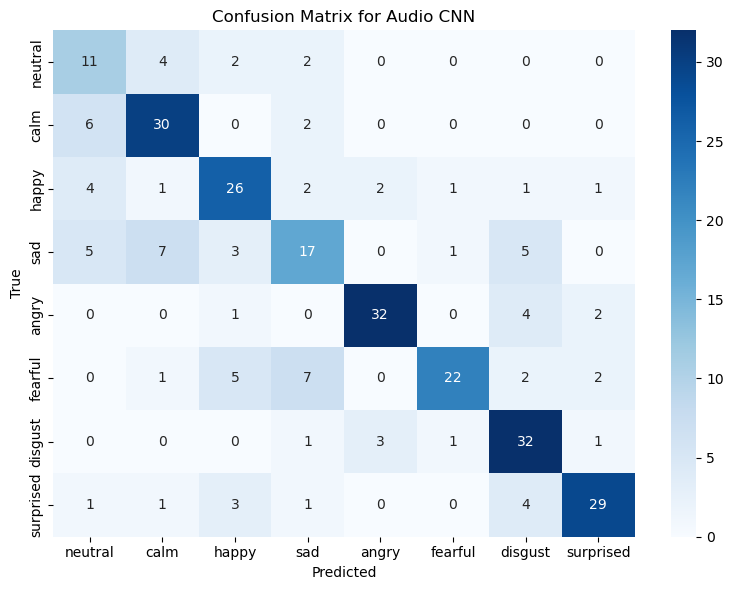

2025-05-08 14:49:16,989 - INFO - Audio CNN Test Accuracy: 69.10%


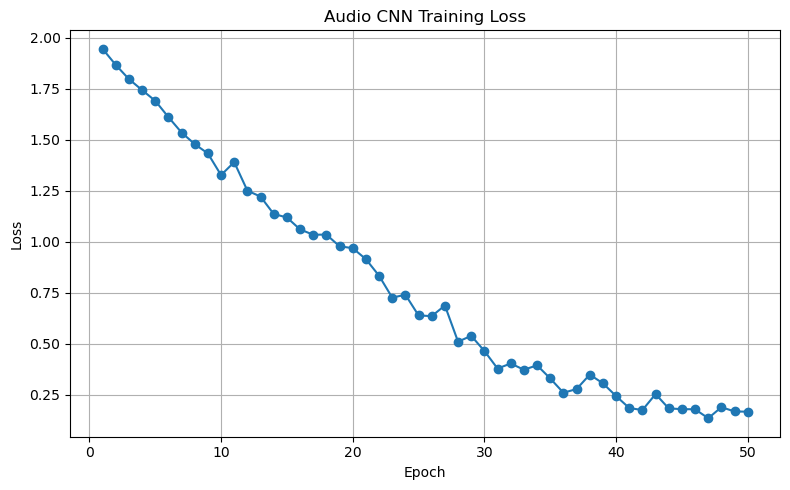

2025-05-08 14:49:17,091 - INFO - Training Text RNN...
2025-05-08 14:49:18,404 - INFO - Epoch 1, Loss: 2.0751, Time: 1.31s
2025-05-08 14:49:19,275 - INFO - Epoch 2, Loss: 2.0688, Time: 0.87s
2025-05-08 14:49:19,934 - INFO - Epoch 3, Loss: 2.0684, Time: 0.66s
2025-05-08 14:49:21,329 - INFO - Epoch 4, Loss: 2.0633, Time: 1.39s
2025-05-08 14:49:22,681 - INFO - Epoch 5, Loss: 2.0710, Time: 1.35s
2025-05-08 14:49:23,693 - INFO - Epoch 6, Loss: 2.0599, Time: 1.01s
2025-05-08 14:49:23,994 - INFO - Epoch 7, Loss: 2.0604, Time: 0.30s
2025-05-08 14:49:25,263 - INFO - Epoch 8, Loss: 2.0577, Time: 1.27s
2025-05-08 14:49:26,592 - INFO - Epoch 9, Loss: 2.0523, Time: 1.33s
2025-05-08 14:49:28,020 - INFO - Epoch 10, Loss: 2.0427, Time: 1.43s
2025-05-08 14:49:29,189 - INFO - Epoch 11, Loss: 2.0394, Time: 1.17s
2025-05-08 14:49:30,400 - INFO - Epoch 12, Loss: 2.0277, Time: 1.21s
2025-05-08 14:49:31,798 - INFO - Epoch 13, Loss: 2.0212, Time: 1.40s
2025-05-08 14:49:33,162 - INFO - Epoch 14, Loss: 2.0095, T

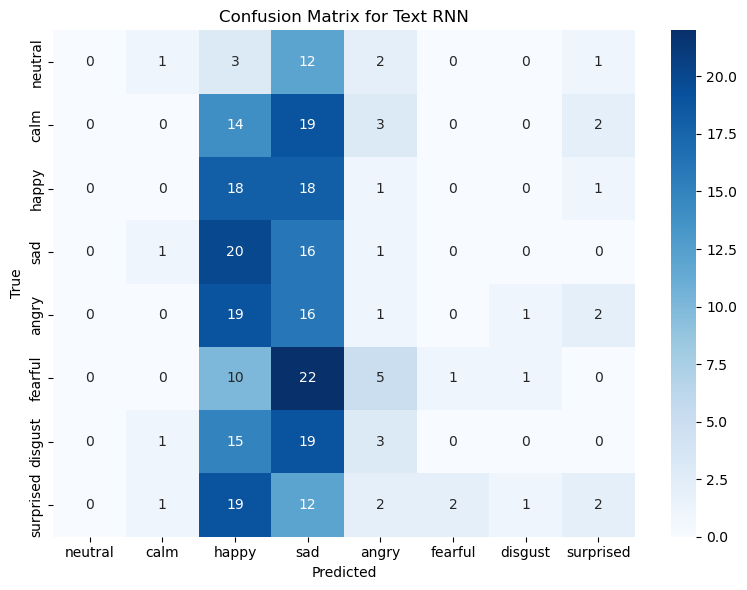

2025-05-08 14:50:13,893 - INFO - Text RNN Test Accuracy: 13.19%


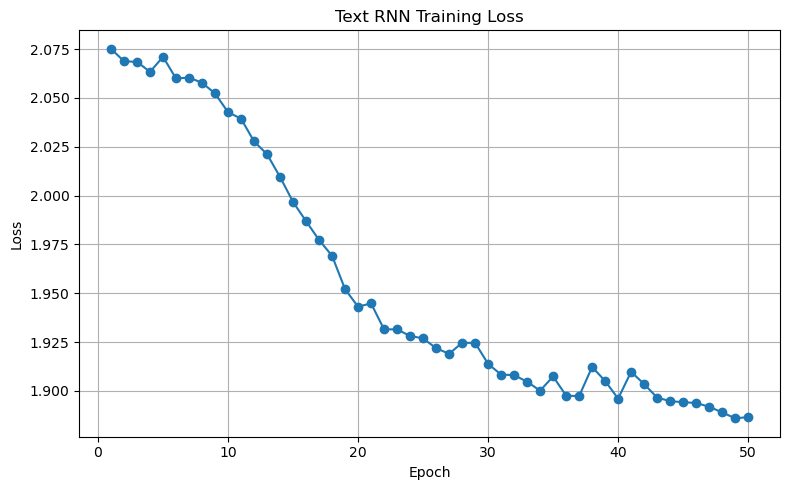

2025-05-08 14:50:13,987 - INFO - Training Multimodal Model...
2025-05-08 14:50:16,261 - INFO - Epoch 1, Loss: 0.9356, Time: 2.27s
2025-05-08 14:50:18,716 - INFO - Epoch 2, Loss: 0.3698, Time: 2.45s
2025-05-08 14:50:20,319 - INFO - Epoch 3, Loss: 0.2606, Time: 1.60s
2025-05-08 14:50:22,075 - INFO - Epoch 4, Loss: 0.2360, Time: 1.75s
2025-05-08 14:50:23,812 - INFO - Epoch 5, Loss: 0.2241, Time: 1.74s
2025-05-08 14:50:26,040 - INFO - Epoch 6, Loss: 0.2235, Time: 2.23s
2025-05-08 14:50:28,117 - INFO - Epoch 7, Loss: 0.1664, Time: 2.08s
2025-05-08 14:50:30,152 - INFO - Epoch 8, Loss: 0.1452, Time: 2.03s
2025-05-08 14:50:31,968 - INFO - Epoch 9, Loss: 0.1515, Time: 1.82s
2025-05-08 14:50:33,284 - INFO - Epoch 10, Loss: 0.1065, Time: 1.32s
2025-05-08 14:50:35,079 - INFO - Epoch 11, Loss: 0.1296, Time: 1.79s
2025-05-08 14:50:37,120 - INFO - Epoch 12, Loss: 0.0937, Time: 2.04s
2025-05-08 14:50:39,257 - INFO - Epoch 13, Loss: 0.1500, Time: 2.14s
2025-05-08 14:50:41,241 - INFO - Epoch 14, Loss: 0

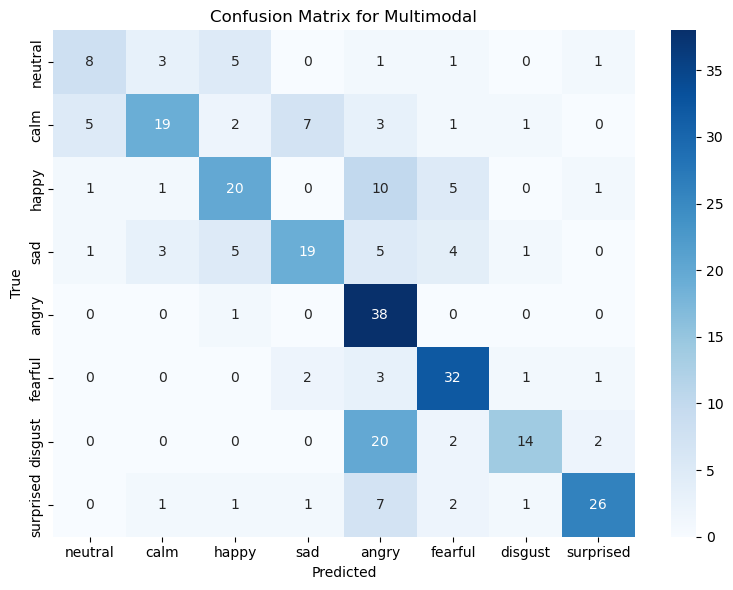

2025-05-08 14:51:49,146 - INFO - Multimodal Model Test Accuracy: 61.11%


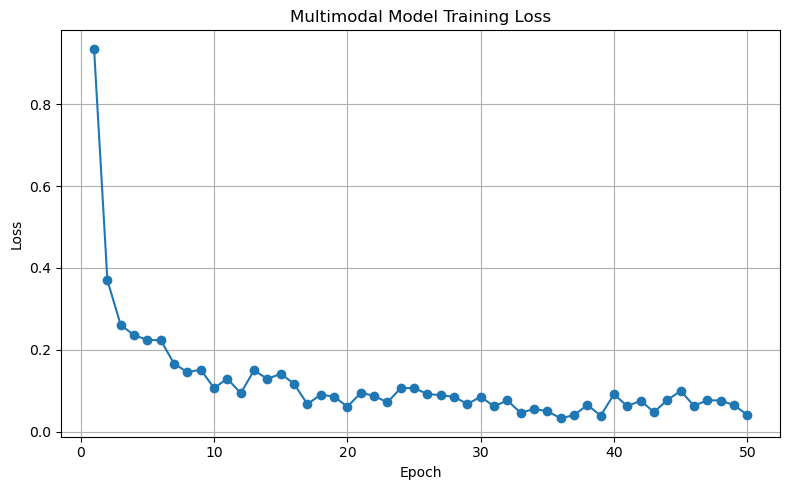

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np
import json
from torch.amp import GradScaler, autocast
import logging
import time
import pickle
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
base_dir = '/home/gagan/Downloads'  # Path to Actor_XX folders
preferred_dir = os.path.join(base_dir, 'audio_speech_actors_01-24')  # Preferred RAVDESS folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs =50
batch_size = 16
transcript_file = 'transcripts.json'
spectrogram_dir = 'spectrograms'
num_workers = 4
transcription_batch_size = 16
max_audio_length = 480000  # 30s at 16kHz
fixed_spec_length = 280  # Fixed time frames for spectrograms
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Clear spectrogram directory
if os.path.exists(spectrogram_dir):
    shutil.rmtree(spectrogram_dir)
os.makedirs(spectrogram_dir, exist_ok=True)

def check_gpu_memory():
    """Check if sufficient GPU memory is available (>4GB free)."""
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        free = total_memory - allocated
        logging.info(f"GPU Memory: Total={total_memory:.2f}GB, Allocated={allocated:.2f}GB, Free={free:.2f}GB")
        return free > 4
    logging.error("CUDA not available")
    return False

def get_emotion(filename):
    """Extract emotion label from filename (0-7)."""
    try:
        parts = filename.split('-')
        emotion = int(parts[2])
        return emotion - 1
    except Exception as e:
        logging.error(f"Invalid filename format {filename}: {e}")
        return -1

def pad_waveform(waveform, target_length=480000):
    """Pad or truncate waveform to target length."""
    if waveform is None or waveform.numel() == 0:
        logging.error("Empty or invalid waveform")
        return torch.zeros(target_length)
    current_length = waveform.size(-1)
    if current_length > target_length:
        waveform = waveform[..., :target_length]
    elif current_length < target_length:
        pad_amount = target_length - current_length
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount), mode='constant', value=0)
    return waveform

def batch_generate_transcripts(audio_paths, batch_size=16):
    """Generate transcripts using Whisper in batches."""
    if not check_gpu_memory():
        raise RuntimeError("Insufficient GPU memory for transcription")
    
    processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny").to(device)
    transcripts = []
    
    for i in range(0, len(audio_paths), batch_size):
        batch_paths = audio_paths[i:i+batch_size]
        waveforms = []
        valid_paths = []
        for path in batch_paths:
            try:
                waveform, sample_rate = torchaudio.load(path)
                if waveform.numel() == 0 or waveform.shape[0] > 1:
                    logging.error(f"Invalid waveform in {path}: {waveform.shape}")
                    continue
                if sample_rate != 16000:
                    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                    waveform = resampler(waveform)
                waveform = pad_waveform(waveform, max_audio_length)
                waveforms.append(waveform.squeeze(0).numpy())
                valid_paths.append(path)
            except Exception as e:
                logging.error(f"Failed to load {path}: {e}")
                continue
        
        if not waveforms:
            logging.error(f"Batch {i//batch_size + 1} empty, skipping")
            transcripts.extend([""] * len(batch_paths))
            continue
        
        try:
            inputs = processor(
                waveforms,
                return_tensors="pt",
                sampling_rate=16000,
                padding="max_length",
                max_length=3000,
                truncation=False,
                return_attention_mask=True
            ).to(device)
            with torch.no_grad():
                predicted_ids = model.generate(inputs["input_features"], max_length=448)
            batch_transcripts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            transcripts.extend(batch_transcripts + [""] * (len(batch_paths) - len(batch_transcripts)))
            logging.info(f"Transcribed batch {i//batch_size + 1}/{len(audio_paths)//batch_size + 1}")
            del inputs, predicted_ids
        except Exception as e:
            logging.error(f"Batch transcription error for files {valid_paths}: {e}")
            transcripts.extend([""] * len(batch_paths))
        
        torch.cuda.empty_cache()
    
    del model, processor
    torch.cuda.empty_cache()
    return transcripts

def compute_spectrogram(waveform, mel_transform, fixed_length=280):
    """Compute and pad/truncate mel-spectrogram to [1, 128, fixed_length]."""
    if waveform.numel() == 0 or waveform.shape[0] > 1:
        logging.error("Invalid waveform for spectrogram")
        return torch.zeros(1, 128, fixed_length)
    
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mel_spec = mel_transform(waveform)
    log_mel_spec = torch.log(mel_spec + 1e-6)
    
    current_length = log_mel_spec.size(2)
    if current_length > fixed_length:
        log_mel_spec = log_mel_spec[:, :, :fixed_length]
    elif current_length < fixed_length:
        pad_amount = fixed_length - current_length
        log_mel_spec = nn.functional.pad(log_mel_spec, (0, pad_amount), mode='constant', value=0)
    
    expected_shape = (1, 128, fixed_length)
    if log_mel_spec.shape != expected_shape:
        logging.error(f"Unexpected spectrogram shape {log_mel_spec.shape}, expected {expected_shape}")
        return torch.zeros(1, 128, fixed_length)
    
    return log_mel_spec

def load_data():
    """Load and preprocess RAVDESS dataset."""
    logging.info("Starting data loading")
    start_time = time.time()
    
    ravdess_pattern = re.compile(r'\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}\.wav')
    audio_files = []
    seen_files = set()
    actor_counts = Counter()
    duplicate_files = []
    
    for root, _, files in os.walk(base_dir):
        if any(root.endswith(f'Actor_{i:02d}') for i in range(1, 25)):
            actor_id = os.path.basename(root)
            is_preferred = root.startswith(preferred_dir)
            for file in files:
                if file.endswith('.wav') and ravdess_pattern.match(file):
                    file_path = os.path.join(root, file)
                    if file_path not in seen_files:
                        if is_preferred or not any(fp.startswith(preferred_dir) for fp in seen_files):
                            audio_files.append(file_path)
                            seen_files.add(file_path)
                            actor_counts[actor_id] += 1
                    else:
                        duplicate_files.append(file_path)
    
    filtered_audio_files = []
    for actor_id in [f'Actor_{i:02d}' for i in range(1, 25)]:
        actor_files = [f for f in audio_files if os.path.basename(os.path.dirname(f)) == actor_id]
        if len(actor_files) > 60:
            actor_files = sorted(actor_files)[:60]
            logging.warning(f"Actor {actor_id} has {len(actor_files)} files, keeping 60")
        filtered_audio_files.extend(actor_files)
    
    audio_files = filtered_audio_files
    
    if duplicate_files:
        logging.warning(f"Found {len(duplicate_files)} duplicate files: {duplicate_files[:10]}")
    
    logging.info(f"Total audio files after validation: {len(audio_files)}")
    if len(audio_files) != 1440:
        logging.warning(f"Expected 1440 files, found {len(audio_files)}")
    
    all_data = []
    for audio_file in audio_files:
        filename = os.path.basename(audio_file)
        label = get_emotion(filename)
        if label >= 0:
            all_data.append((audio_file, label))
    
    labels = [label for _, label in all_data]
    counter = Counter(labels)
    logging.info(f"Emotion distribution: {counter}")
    
    # Visualize emotion distribution
    plt.figure(figsize=(8, 5))
    plt.hist(labels, bins=8, align='left', rwidth=0.8)
    plt.xticks(range(8), emotion_labels, rotation=45)
    plt.title("Emotion Distribution in RAVDESS Dataset")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    if os.path.exists(transcript_file):
        with open(transcript_file, 'r') as f:
            all_transcripts = json.load(f)
    else:
        logging.info("Generating transcripts...")
        all_transcripts = batch_generate_transcripts([path for path, _ in all_data])
        with open(transcript_file, 'w') as f:
            json.dump(all_transcripts, f)
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=48000, n_fft=1024, hop_length=512, n_mels=128
    )
    spectrogram_paths = []
    sample_spectrogram = None
    for idx, (audio_path, label) in enumerate(all_data):
        spec_path = os.path.join(spectrogram_dir, f"spec_{idx}.pkl")
        for attempt in range(2):  # Retry once for corrupted files
            try:
                waveform, sample_rate = torchaudio.load(audio_path)
                if sample_rate != 48000:
                    resampler = torchaudio.transforms.Resample(sample_rate, 48000)
                    waveform = resampler(waveform)
                log_mel_spec = compute_spectrogram(waveform, mel_transform, fixed_length=fixed_spec_length)
                with open(spec_path, 'wb') as f:
                    pickle.dump(log_mel_spec, f)
                if idx == 0:  # Save first spectrogram for visualization
                    sample_spectrogram = log_mel_spec.squeeze(0).numpy()
                break
            except Exception as e:
                logging.error(f"Attempt {attempt+1} failed for {audio_path}: {e}")
                if attempt == 1:
                    log_mel_spec = torch.zeros(1, 128, fixed_spec_length)
                    with open(spec_path, 'wb') as f:
                        pickle.dump(log_mel_spec, f)
        spectrogram_paths.append(spec_path)
    
    # Visualize sample spectrogram
    if sample_spectrogram is not None:
        plt.figure(figsize=(10, 4))
        plt.imshow(sample_spectrogram, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Log Magnitude')
        plt.title("Sample Mel-Spectrogram")
        plt.xlabel("Time Frames")
        plt.ylabel("Mel Bins")
        plt.tight_layout()
        plt.show()
    
    train_idx, test_idx = train_test_split(
        list(range(len(all_data))),
        test_size=0.2,
        stratify=[label for _, label in all_data],
        random_state=42
    )
    train_data = [(spectrogram_paths[i], all_data[i][1]) for i in train_idx]
    test_data = [(spectrogram_paths[i], all_data[i][1]) for i in test_idx]
    train_transcripts = [all_transcripts[i] for i in train_idx]
    test_transcripts = [all_transcripts[i] for i in test_idx]
    
    logging.info(f"Data loading completed in {time.time() - start_time:.2f}s")
    return train_data, test_data, train_transcripts, test_transcripts, mel_transform

def build_vocabulary(transcripts):
    """Build vocabulary from transcripts."""
    all_words = [word for transcript in transcripts for word in transcript.lower().split()]
    unique_words = list(set(all_words))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, word in enumerate(unique_words):
        vocab[word] = i + 2
    max_len = max(len(transcript.split()) for transcript in transcripts if transcript) or 1
    return vocab, max_len

class AudioDataset(Dataset):
    """Dataset for audio spectrograms."""
    def __init__(self, data_list):
        self.data_list = data_list
        self.expected_shape = (1, 128, fixed_spec_length)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        for attempt in range(2):
            try:
                with open(spec_path, 'rb') as f:
                    log_mel_spec = pickle.load(f)
                if log_mel_spec.shape != self.expected_shape:
                    logging.error(f"Invalid shape {log_mel_spec.shape} in {spec_path}")
                    return torch.zeros(self.expected_shape), label
                return log_mel_spec, label
            except Exception as e:
                logging.error(f"Attempt {attempt+1} failed to load {spec_path}: {e}")
                if attempt == 1:
                    return torch.zeros(self.expected_shape), label

class TextDataset(Dataset):
    """Dataset for text transcripts."""
    def __init__(self, transcripts, labels, vocab, max_len):
        self.transcripts = transcripts
        self.labels = labels
        self.word_to_idx = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.transcripts)
    
    def __getitem__(self, idx):
        transcript = self.transcripts[idx].lower().split() if self.transcripts[idx] else ["<UNK>"]
        label = self.labels[idx]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in transcript]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), label

class MultimodalDataset(Dataset):
    """Dataset for audio and text data."""
    def __init__(self, data_list, transcripts, vocab, max_len):
        self.data_list = data_list
        self.transcripts = transcripts
        self.word_to_idx = vocab
        self.max_len = max_len
        self.expected_shape = (1, 128, fixed_spec_length)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        spec_path, label = self.data_list[idx]
        transcript = self.transcripts[idx]
        for attempt in range(2):
            try:
                with open(spec_path, 'rb') as f:
                    log_mel_spec = pickle.load(f)
                if log_mel_spec.shape != self.expected_shape:
                    logging.error(f"Invalid shape {log_mel_spec.shape} in {spec_path}")
                    log_mel_spec = torch.zeros(self.expected_shape)
                break
            except Exception as e:
                logging.error(f"Attempt {attempt+1} failed to load {spec_path}: {e}")
                if attempt == 1:
                    log_mel_spec = torch.zeros(self.expected_shape)
        words = transcript.lower().split() if transcript else ["<UNK>"]
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in words]
        if len(indices) < self.max_len:
            indices += [self.word_to_idx["<PAD>"]] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        text_input = torch.tensor(indices, dtype=torch.long)
        return log_mel_spec, text_input, label

class AudioCNN(nn.Module):
    """Enhanced CNN for spectrogram emotion classification."""
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def get_features(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return x

class TextRNN(nn.Module):
    """Enhanced bidirectional LSTM for text emotion classification."""
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate forward and backward
        out = self.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
    def get_features(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.relu(self.fc1(hidden))

class MultimodalModel(nn.Module):
    """Enhanced multimodal model combining audio and text features."""
    def __init__(self, audio_model, text_model):
        super(MultimodalModel, self).__init__()
        self.audio_model = audio_model
        self.text_model = text_model
        self.fc1 = nn.Linear(256 + 128, 256)  # Audio: 256, Text: 128
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model.get_features(audio_input)
        text_feat = self.text_model.get_features(text_input)
        combined = torch.cat((audio_feat, text_feat), dim=1)
        x = self.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

def train_model(model, loader, criterion, optimizer, epochs, is_multimodal=False, accum_steps=2):
    """Train model and return loss history."""
    scaler = torch.amp.GradScaler('cuda')
    losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        optimizer.zero_grad()
        
        for i, batch in enumerate(loader):
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(device), text_input.to(device), labels.to(device)
                    with torch.amp.autocast('cuda'):
                        outputs = model(audio_input, text_input)
                        loss = criterion(outputs, labels)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    with torch.amp.autocast('cuda'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                loss = loss / accum_steps
                scaler.scale(loss).backward()
                if (i + 1) % accum_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                running_loss += loss.item() * accum_steps
            except RuntimeError as e:
                logging.error(f"Training error in batch {i}: {e}")
                torch.cuda.empty_cache()
                continue
        
        epoch_loss = running_loss / len(loader)
        losses.append(epoch_loss)
        logging.info(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")
    
    return losses

def evaluate_model(model, loader, is_multimodal=False, model_name="Model"):
    """Evaluate model and display confusion matrix."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            try:
                if is_multimodal:
                    audio_input, text_input, labels = batch
                    audio_input, text_input, labels = audio_input.to(device), text_input.to(device), labels.to(device)
                    with torch.amp.autocast('cuda'):
                        outputs = model(audio_input, text_input)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    with torch.amp.autocast('cuda'):
                        outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                logging.error(f"Evaluation error: {e}")
                continue
    
    if total == 0:
        logging.error(f"No valid samples evaluated for {model_name}")
        return 0.0
    
    accuracy = 100 * correct / total
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(8))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return accuracy

def main():
    """Main function to run the enhanced emotion recognition pipeline."""
    # Load data
    train_data, test_data, train_transcripts, test_transcripts, mel_transform = load_data()
    
    # Build vocabulary
    vocab, max_len = build_vocabulary(train_transcripts + test_transcripts)
    
    # Create datasets
    train_audio_dataset = AudioDataset(train_data)
    test_audio_dataset = AudioDataset(test_data)
    train_text_dataset = TextDataset(train_transcripts, [label for _, label in train_data], vocab, max_len)
    test_text_dataset = TextDataset(test_transcripts, [label for _, label in test_data], vocab, max_len)
    train_multimodal_dataset = MultimodalDataset(train_data, train_transcripts, vocab, max_len)
    test_multimodal_dataset = MultimodalDataset(test_data, test_transcripts, vocab, max_len)
    
    # Create dataloaders
    train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    train_text_loader = DataLoader(train_text_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_text_loader = DataLoader(test_text_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    train_multimodal_loader = DataLoader(train_multimodal_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_multimodal_loader = DataLoader(test_multimodal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Initialize models
    criterion = nn.CrossEntropyLoss()
    torch.cuda.empty_cache()
    
    # Train Audio CNN
    audio_model = AudioCNN().to(device)
    audio_optimizer = optim.Adam(audio_model.parameters(), lr=0.001)
    logging.info("Training Audio CNN...")
    audio_losses = train_model(audio_model, train_audio_loader, criterion, audio_optimizer, num_epochs)
    audio_accuracy = evaluate_model(audio_model, test_audio_loader, model_name="Audio CNN")
    logging.info(f"Audio CNN Test Accuracy: {audio_accuracy:.2f}%")
    
    # Plot Audio CNN loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), audio_losses, marker='o')
    plt.title("Audio CNN Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    torch.cuda.empty_cache()
    
    # Train Text RNN
    text_model = TextRNN(len(vocab), embedding_dim=64, hidden_dim=128).to(device)
    text_optimizer = optim.Adam(text_model.parameters(), lr=0.001)
    logging.info("Training Text RNN...")
    text_losses = train_model(text_model, train_text_loader, criterion, text_optimizer, num_epochs)
    text_accuracy = evaluate_model(text_model, test_text_loader, model_name="Text RNN")
    logging.info(f"Text RNN Test Accuracy: {text_accuracy:.2f}%")
    
    # Plot Text RNN loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), text_losses, marker='o')
    plt.title("Text RNN Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    torch.cuda.empty_cache()
    
    # Train Multimodal Model
    multimodal_model = MultimodalModel(audio_model, text_model).to(device)
    multimodal_optimizer = optim.Adam(multimodal_model.parameters(), lr=0.001)
    logging.info("Training Multimodal Model...")
    multimodal_losses = train_model(multimodal_model, train_multimodal_loader, criterion, multimodal_optimizer, num_epochs, is_multimodal=True)
    multimodal_accuracy = evaluate_model(multimodal_model, test_multimodal_loader, is_multimodal=True, model_name="Multimodal")
    logging.info(f"Multimodal Model Test Accuracy: {multimodal_accuracy:.2f}%")
    
    # Plot Multimodal loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), multimodal_losses, marker='o')
    plt.title("Multimodal Model Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()